In [1]:
%matplotlib inline

import json
import os
import glob
import boto3

import numpy as np
import matplotlib.pylab as plt

## boto3 client 

In [2]:
client = boto3.client('s3',
                     aws_access_key_id = os.getenv('aws_access_key'),
                     aws_secret_access_key = os.getenv('aws_secret_key'),
                     )

In [4]:
bucket_list = client.list_buckets()

In [5]:
bucket_name = 'summit-demo'

In [15]:
object_list = client.list_objects_v2(Bucket = bucket_name)['Contents']

In [21]:
len(object_list) #TODO: need paginator to get > 1000 objects

1000

In [39]:
paginator = client.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=bucket_name, Prefix='ai-sensor/')

key_list = []
for p in pages:
    for o in p['Contents']:
        key_list.append(o['Key'])

In [40]:
len(key_list)

17470

In [41]:
key_list[0]

'ai-sensor/2022-02-24T17:50:02.840805.json'

In [42]:
data_list = []
for k in key_list:
    data = client.get_object(Bucket = bucket_name, Key = k)['Body'].readlines()
    data_list.append(data)

## Plotting

In [50]:
data = [json.loads(d[0].decode('utf-8')) for d in data_list]

In [87]:
json.dump(data, open('data.json', 'w'))

In [52]:
uniq_keys = np.unique([list(d['features'].keys())[0] for d in data])

In [53]:
uniq_keys

array(['led_1', 'led_2', 'led_3', 'led_4', 'light', 'temperature'],
      dtype='<U11')

In [80]:
def get_data(data, colname):
    if colname == 'temperature' or colname == 'light':
        field = 'value'
    else:
        field = 'state'
    
    return [d['features'][colname][field] for d in data if list(d['features'].keys())[0]==colname]

array([1024])

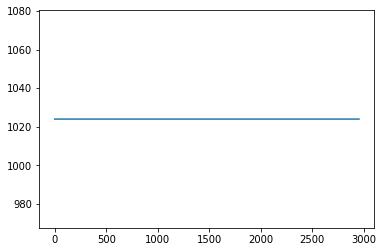

In [81]:
light_data = get_data(data, 'light')
plt.plot(light_data)
np.unique(light_data)

array([23.4, 23.5, 23.6, 23.7, 23.8, 23.9, 24. , 24.3, 24.4, 24.7, 24.9,
       25. , 25.2, 25.5, 25.8, 25.9, 26.1, 26.3, 26.4, 26.5, 26.6, 26.7,
       26.8, 26.9, 27. , 27.1, 27.2, 27.3, 28.3, 29.3, 30.1, 30.2])

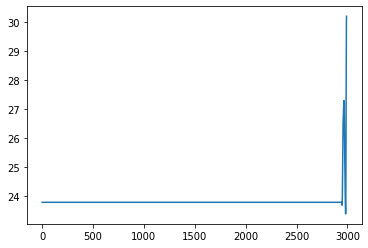

In [82]:
temp_data = get_data(data, 'temperature')

plt.plot(temp_data)
np.unique(temp_data)

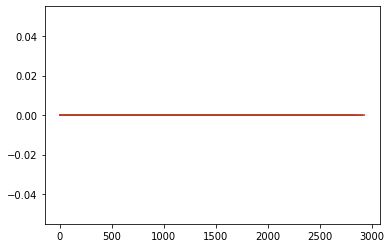

In [83]:
plt.plot(get_data(data, 'led_1'))
plt.plot(get_data(data, 'led_2'))
plt.plot(get_data(data, 'led_3'))
plt.plot(get_data(data, 'led_4'))

In [91]:
len(temp_data)

2992

In [92]:
len(light_data)

2956

In [93]:
len(get_data(data, 'led_1'))

2840

# Synthetic data examples

In [104]:
def gen_data(mean, std, N=1000):
    '''This is not representative of time-series
    data since all samples are generated independently
    i.e. no correlations but the goal is to show simple
    strategies for scoring so it's okay
    '''
    return np.random.normal(loc=mean, scale=std, size=N)

In [99]:
N = 100

In [102]:
acc_x = gen_data(1, 0.2, N)
acc_y = gen_data(1, 0.2, N)
acc_z = gen_data(1, 0.2, N)
light = gen_data(3, 2, N)
temp = gen_data(10, 1, N)

#### Note: no units assumed in the plots below i.e. these could be some uncalibrated measurements

Text(0.5, 1.0, 'acceleration magnitude')

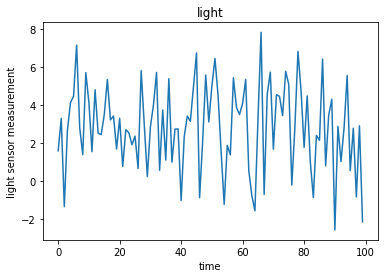

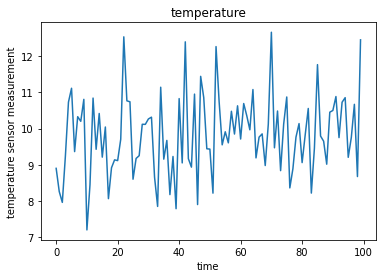

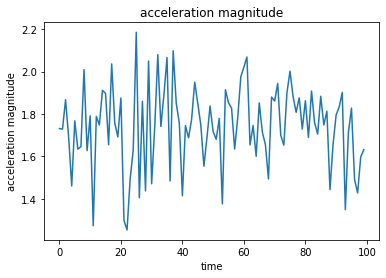

In [111]:
plt.figure()
plt.plot(light)
plt.xlabel('time')
plt.ylabel('light sensor measurement')
plt.title('light')

plt.figure()
plt.plot(temp)
plt.xlabel('time')
plt.ylabel('temperature sensor measurement')
plt.title('temperature')

plt.figure()
plt.plot(np.sqrt(acc_x**2 + acc_y**2 + acc_z**2))
plt.xlabel('time')
plt.ylabel('acceleration magnitude')
plt.title('acceleration magnitude')

### Strategy 1: make a histogram and pick percentiles (only working with light but applies to temperature and acceleration magnitude too)

{10: -0.7063584050603715, 25: 1.5124502094654038, 50: 2.869665155221126, 75: 4.499906055100529, 90: 5.71497347058922}


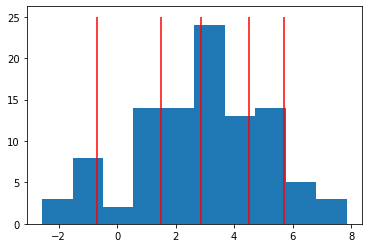

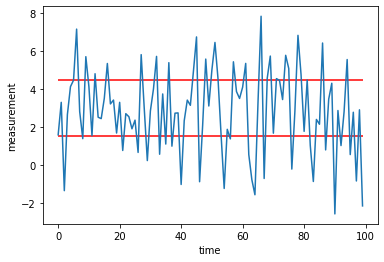

In [137]:
_ = plt.hist(light) #plot distribution of values

p_list = [10, 25, 50, 75, 90] #compute these percentiles
t = np.percentile(light, q=p_list)
mapping = dict(zip(p_list, t))

print(mapping)
#plot percentiles on histogram
for p in p_list:
    plt.vlines(mapping[p], 0, 25, color='r', label=p)
    
plt.figure()
plt.plot(light)
plt.xlabel('time')
plt.ylabel('measurement')

low_p = 25
high_p = 75
plt.hlines(mapping[low_p], 0, N-1, color='r')
plt.hlines(mapping[high_p], 0, N-1, color='r')

### Strategy 2: ask user to perform action to get maximum light/temperature/acceleration and then scale data to range 0-1 (acceleration magnitude minimum is already 1. not sure about light/temperature sensors)

In [ ]:
#will add soon